In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import random
random.seed(11)

# Introduction:

Thinkful: *Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.*

This large dataset (each file contains about 7 million flights) records basic information about US airline flights such as date, carrier, duration, and predicted and actual arrival and departure times.  It includes scheduled flights that were subsequently cancelled.  Our task is to predict delay amounts.

### Choice 1: Classification vs Regression

There are two fundamental ways to frame this problem.  We could frame it as a <b>classification problem</b>, with delays binned into categories such as:
- early (by at least 15 minutes)
- on time (+/- 15 minutes)
- 15 to 60 minute delay
- 60 to 120 minute delay
- 120+ minute delay
- cancellation

This model would have several advantages: first, it would accord with the categorical definition of lateness given by the US Department of Transportation (USDT).  (In typical fashion, Thinkful has simply got this detail wrong – from the USDT website: "A flight is considered delayed when it arrived 15 or more minutes than the schedule.")  Second, it could provide a fairly high degree of accuracy in its predictions.  Third, it allows cancelled flights to be integrated into the model even though they are non-continuous with delayed flights.  The disadvantages are that it limits the precision of information the model can communicate, and it draws arbitrary category lines between delay intervals, which may diminish its accuracy.

This problem could also be framed as a <b>regression problem</b>: we predict the arrival time of the plane and subtract the scheduled arrival time to give the +/- minutes early or late.  The main disadvantage of this model is that it could not accurately incorporate cancellations, which would need to be removed and/or predicted separately.  However, the regression version of this problem comes with two major advantages.  First, arrival time is inherently a continuous variable, and all other things being equal a model will be better and more accurate if it treats variables according to their actual nature.  Second, it yields the maximum information generated by the model.  Users of a regression model can easily retroactively bin outputs into categories like those listed above; they can't retroactively get minute-amount predictions from a classification model.

Given the nonspecificity of the prompt, and that we don't know for what purpose we're predicting delays, we should err on the side of maximum information.  Therefore <b>we'll proceed with the regression model for now</b>, and potentially take a brief look at a classification version at the end of the notebook.

### Choice 2: prediction in advance, or in-flight

We're also not told here whether we wish to predict delays in advance of the day of a flight, or once a flight is in the air. Several columns (aircraft arrival delay, taxi time out to the runway, departure time) would only be known after or just before takeoff.  We could therefore use them for in-flight delay prediction, but not in-advance prediction.

As it turns out, in-flight delay prediction is almost entirely trivial.  Takeoff delay correlates with arrival delay to a correlation of r^2 = 0.93, so we can predict in-flight delay with a high degree of accuracy before creating any multi-feature model whatsoever.

Instead, we'll focus on in-advance prediction here.  We'll define in advance as knowable before the day takeoff, so we'll be building a model that can predict flight delays by midnight of the previous day.  We will not use any features that could not be known by that time.

### Choice 3: expanding our featureset:

The information here is actually fairly sparse -- especially for predicting flights in advance.  We could actually obtain significantly more data from the data given here.  In particular, we could scrape data from the national weather service for the departure and arrival cities on the date of the flight.  In practice, the weather is known to a high degree of accuracy the day before a flight, so this would be realistic and useful predictive information.  Since weather is one of the main causes of delays, these data points would likely add significant accuracy to this dataset.

It would also be useful to have a measure of air traffic busyness (normalized to median or mean departure/arrival numbers for each airport), since that is a major cause of delays that is also known in advance.  Unlike weather reports, this could be calculated from the dataset itself.

Finally, for in-flight delay prediction, or even just same-day prediction, it would be useful to know how many other flights have been delayed at the arrival and departure airports the day before - this might serve as a metric of bad weather that spans several days.  It may also be useful to know how many flights are delayed at that airport in the previous month (some airports may be less efficient than others).

For this project, we'll proceed with only the information included in this dataset - including air traffic busyness and recent delays at the arrival and departure airports, since those can be extrapolated from existing columns.  This means we won't scrape weather data based on the dates in the dataset - but we'll keep in mind that this would probably be the next step in making these predictions more accurate.

# Load and clean


In [122]:
# raw04_df = pd.read_csv('practice/2004.csv')
# raw05_df = pd.read_csv('practice/2005.csv')
# raw06_df = pd.read_csv('practice/2006.csv')
# raw07_df = pd.read_csv('practice/2007.csv')
raw08_df = pd.read_csv('practice/2008.csv')

In [84]:
print(raw08_df.shape)
raw08_df.head()

(7009728, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


As described above, for delay prediction we'll only be working on non-cancelled, non-diverted flights.  So our first task - which will eliminate most of our null values (missing arrival times, for instance), is to drop all cancelled and diverted flights.

In [170]:
flights08_df = raw08_df[(raw08_df.Cancelled==0) & (raw08_df.Diverted==0)]

Now we'll do some miscellaneous other cleaning:

In [171]:
# drop the five flights with missing tail numbers:
flights08_df = flights08_df[flights08_df.TailNum.isnull()==False]

# drop cancellation code (they're all null, since we've dropped cancelled flights)
flights08_df.drop('CancellationCode', axis=1, inplace=True)

# for delay columns (minutes delayed for weather, carrier issues, etc):
# - convert nulls to 0 (since no delay is a delay of 0 minutes)
# - convert from string to int
for colname in ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']:
    flights08_df[colname] = flights08_df[colname].fillna(value='0')
    flights08_df[colname] = flights08_df[colname].astype(int)
    
# flight number (currently an int) is actually a categorical variable.  However, two numerical features are meaningful:
# odd-vs-even traditionally indicates East/North - vs - South/West bound flights:
flights08_df['flNumOdd'] = flights08_df.FlightNum%2
# number of digits indicates premium vs normal vs regional flight;  
# (and we'll convert to string first to make FlightNum categorical)
flights08_df['FlightNum'] = flights08_df.FlightNum.astype(str)
flights08_df['flNumDigitCount'] = flights08_df.FlightNum.str.len()

# we'll need scheduled departure time as a Datetime object for feature generation:
# hour = flights08_df.CRSDepTime.astype(int).astype(str).str.slice(stop=-2)
# minute = flights08_df.CRSDepTime.astype(int).astype(str).str.slice(start=-2)
# flights08_df['dTime'] = pd.to_datetime({'year':flights08_df.Year, 'month':flights08_df.Month, 'day':flights08_df.DayofMonth, 'hour':hour, 'minute':minute})
flights08_df['dDate'] = pd.to_datetime({'year':flights08_df.Year, 'month':flights08_df.Month, 'day':flights08_df.DayofMonth})

# times are formatted as hhmm integers, meaning that hours are represented as being a hundred minutes long.
# we'll convert these to hour of the day, with decimals representing decimals of a whole hour (not minutes)
time_cols = ['DepTime', 'CRSDepTime','ArrTime', 'CRSArrTime']
for colname in time_cols:
    # hour-in-day = hours + minutes/60
    flights08_df[colname] = (flights08_df.CRSDepTime//100) + (flights08_df.CRSDepTime%100) / 60
    flights08_df[colname] = flights08_df[colname].round(2)
# all our numerical columns are stored as floats but should be ints - they're all whole numbers written as x.0
for colname in flights08_df.columns:
    if flights08_df[colname].dtype == float and colname not in time_cols:
        flights08_df[colname] = flights08_df[colname].astype(int)
        
# distance (miles) and CRSElapsedTime (scheduled air time) have a 0.98 correlation; we'll drop distance
flights08_df.drop('Distance', axis=1, inplace=True)

### Engineered features

In [180]:
flights08_df['dDate'] = pd.to_datetime({'year':flights08_df.Year, 'month':flights08_df.Month, 'day':flights08_df.DayofMonth})

In [211]:
day_departures = flights08_df.groupby(['dDate', 'Origin']).DayofMonth.agg('count')
av_departures = flights08_df.groupby(['Origin']).DayofMonth.agg('count')/365
day_arrivals = flights08_df.groupby(['dDate', 'Dest']).DayofMonth.agg('count')
av_arrivals = flights08_df.groupby(['Dest']).DayofMonth.agg('count')/365
day_departures[:10]

dDate       Origin
2008-01-01  ABE        11
            ABI         8
            ABQ       107
            ABY         1
            ACT         7
            ACV         7
            ADQ         2
            AEX         5
            AGS         3
            ALB        33
Name: DayofMonth, dtype: int64

In [210]:
# get av amount of DELAY on arrivals and takeoffs from origin/date (take average of Delayed column)
# DO BEFORE DROPPING DEP DELAY
# av_arr_delay = flights08_df.groupby(['Month','Origin']).DepDelay.agg(np.mean)
av_dep_delay = flights08_df.groupby(['Month','Dest']).ArrDelay.agg(np.mean)
av_dep_delay[:10]

Month  Dest
1      ABE     15.028133
       ABI      9.459227
       ABQ      6.531727
       ABY     13.443299
       ACT     11.452261
       ACV     33.228782
       ACY      5.862069
       ADK     22.666667
       ADQ      9.280702
       AEX     13.086294
Name: ArrDelay, dtype: float64

In [197]:
departures["2008-01-01"]['ABE']

11

In [221]:
# READ UP ON INDEXES FIRST!!!

# this successfully creates a column containing the number of departures from the origin on THE DAY OF THE FLIGHT
# I just need to change it to contain the number of departures from origin on THE DAY BEFORE FLIGHT
# I can do this by some datetime wrangling (minus timedelta of one)
date_origins = zip(flights08_df.dDate[:20], flights08_df.Origin.values[:20])
[day_departures[date_origin[0]][date_origin[1]] for date_origin in date_origins]

# THEN I CAN REPEAT THIS FORMULA for departures and averages


[223,
 223,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 119,
 30]

In [198]:
day_departures[flights08_df.dDate.values][flights08_df.Origin.values]

ValueError: cannot include dtype 'M' in a buffer

In [194]:
day_departures[flights08_df.dDate.astype(str).values][flights08_df.Origin.values]

TypeError: Expected tuple, got str

In [ ]:
flights08_df.groupby(['Year', 'Month', 'DayofMonth', 'Origin']).agg(np.mean)


In [109]:
# departure delays at the departure airport the day before departure:
dep_delays = flights08_df.
# arrival delays at the arrival airport the day before departure:

# departure delays at the departure airport from the previous month:

# arrival delays at the arrival airport from the previous month:

# traffic (busyness) at the departure airport:

# traffic (busyness) at the arrival airport:

# drop all columns (except target col ArrDelay) that couldn't be known 24 hours before scheduled departure:
non_advance = ['ActualElapsedTime', 'ArrTime', 'AirTime', 'TaxiIn', 'WeatherDelay', 'CarrierDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'Diverted']
flights08_df.drop(non_advance, axis=1, inplace=True)


# Examining the data

In [172]:
flights08_df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flNumOdd,flNumDigitCount,dTime
0,2008,1,3,4,19.92,19.92,0.33,0.33,WN,335,...,0,0,0,0,0,0,0,1,3,2008-01-03 19:55:00
1,2008,1,3,4,7.58,7.58,0.13,0.13,WN,3231,...,0,0,0,0,0,0,0,1,4,2008-01-03 07:35:00
2,2008,1,3,4,6.33,6.33,0.11,0.11,WN,448,...,0,0,0,0,0,0,0,0,3,2008-01-03 06:20:00
3,2008,1,3,4,9.50,9.50,0.16,0.16,WN,1746,...,0,0,0,0,0,0,0,0,4,2008-01-03 09:30:00
4,2008,1,3,4,17.92,17.92,0.30,0.30,WN,3920,...,0,0,2,0,0,0,32,0,4,2008-01-03 17:55:00


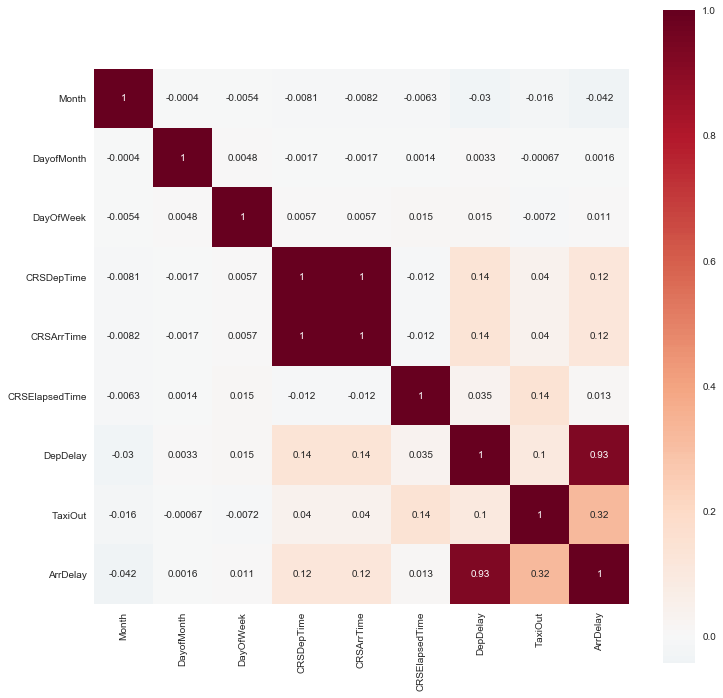

In [108]:
corrCols = ['Month', 'DayofMonth','DayOfWeek','CRSDepTime','CRSArrTime','CRSElapsedTime', 'DepDelay', 'TaxiOut', 'ArrDelay']
plt.figure(figsize=(12,12))
sns.heatmap(flights08_df[corrCols].corr(), square=True, annot=True, center=0, cmap='RdBu_r')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X = flights08_df
y = flights08_df['Cancelled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
# list of all columns unknowable before the plane takes off:
post_takeoff_cols = ['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'Cancelled']
# list of all columns unknowable before the plane lands:
post_landing_cols = ['DepTime', 'DepDelay', 'TaxiIn', 'CancellationCode', 'Cancelled']

# # generate cancellation-prediction datasets
# X_cancel_advance_train = X_train.drop(post_takeoff_cols, axis=1)
# X_cancel_advance_test = X_test.drop('Cancelled', axis=1)
# X_cancel_inflight_train = X_train.drop(post_landing_cols, axis=1)
# X_cancel_inflight_test = X_test.drop(post_landing_cols, axis=1)

# generate delay-prediction datasets for advance prediction and in-flight prediction
X_ad_train = X_train[X_train['Cancelled']==0].drop(post_takeoff_cols, axis=1)
X_ad_test = X_test.drop(post_takeoff_cols, axis=1)[X_test['Cancelled']==0]
X_infl_train = X_train.drop(post_landing_cols, axis=1)[X_train['Cancelled']==0]
X_infl_test = X_test.drop(post_landing_cols, axis=1)[X_test['Cancelled']==0]

In [ ]:
from sklearn.ensemble import 

In [26]:
flights08_df[flights08_df['Cancelled']==0].isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                14215
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    7
ActualElapsedTime      17265
CRSElapsedTime           598
AirTime                17265
ArrDelay               17265
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                 14215
TaxiOut                    0
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5347559
WeatherDelay         5347559
NASDelay             5347559
SecurityDelay        5347559
LateAircraftDelay    5347559
dtype: int64

Our task here is to predict delays, not cancellations.  However, it's within the spirit of the request – and it would be essential to any practical purpose – to predict cancellations as well.  But this is a categorical target.

What I'll use here is a two-step algorithm.  First, we'll make a model to predict cancellations.  For the test set, this model will predict all cancellations and remove them from the dataset.  Then a second model will predict delays for all flights that we don't expect to be cancelled.

In [119]:
flights08_df.CRSArrTime.astype(int).astype(str).str.slice(start=-2) + ":" + flights08_df.CRSArrTime.astype(int).astype(str).str.slice(stop=-2)




0          0:
1          0:
2          0:
3          0:
4          0:
5          0:
6          0:
7          0:
8          0:
9          0:
10         0:
11         0:
12         0:
13         0:
14         0:
15         0:
16         0:
17         0:
18         0:
19         0:
20         0:
21         0:
22         0:
23         0:
24         0:
25         0:
26         0:
27         0:
28         0:
29         0:
           ..
7009698    0:
7009699    0:
7009700    0:
7009701    0:
7009702    0:
7009703    0:
7009704    0:
7009705    0:
7009706    0:
7009707    0:
7009708    0:
7009709    0:
7009710    0:
7009711    0:
7009712    0:
7009713    0:
7009714    0:
7009715    0:
7009716    0:
7009717    0:
7009718    0:
7009719    0:
7009720    0:
7009721    0:
7009722    0:
7009723    0:
7009724    0:
7009725    0:
7009726    0:
7009727    0:
Name: CRSArrTime, Length: 6855024, dtype: object

# Examining the data

In [ ]:
# plot the delay distribution!!!  barplot, and boxplot / violinplot by carrier, etc.
sns.distplot()

WHAT TO USE:
CLASSIFICATION: probably kernel approximation & SGD Classifier.  Try random forest; probably takes too long.
REGRESSION: SGD Regressor for quick baseline.  Kernel approximation.  XGBoost.

# Engineering additional features

As discussed in the introduction, we'll add a number of features here extrapolated from the data in the dataset:
- <b>arr_traffic</b>: how many flights are scheduled to arrive at the arrival airport that day, as a percentage of the airport's average number of arrivals
- <b>dep_traffic</b>: how many flights are scheduled to depart from the departure airport that day, as a percentage of the airport's average number of departures
- <b>arr_delays</b>: how many flights have been delayed arriving at the arrival airport that day
- <b>dep_delays</b>: how many flights have been delayed departing from the departure airport that day
- <b>dep_delays_adv</b>: how many flights have been delayed arriving at the arrival airport the day before the scheduled departure day (can be used for advance prediction)
- <b>arr_delays_adv</b>: how many flights have been delayed departing from the departure airport the day before the scheduled departure day (can be used for advance prediction)
- <b>dep_delays_daily</b>: number of delayed departures per day at the departure airport over the past month
- <b>arr_delays_daily</b>: number of delayed arrivals per day at the arrival airport over the past month

# Model selection

# Model tuning